In [1]:
import subprocess
import os
import logging
import re
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from NGS import HiCTools as HT

In [10]:
test = np.zeros((6, 6))
test

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [19]:
x, y = HT.slidingDiamond(test, sideLen=5)

In [18]:
x

array([-1.5, -0.5,  0.5,  1.5])

# Define plotting parameters

In [2]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define Samples

In [3]:
def runSCC(fileIterator, binSize, maxdist=100000, subsample=0):
    """runs hicreppy scc on a pair of file returned
    by fileIterator for files located in fileDir."""
    # dispatch processes
    processList = []
    for file1, file2 in fileIterator:
        mat1 = f"{file1}::/resolutions/{binSize}"
        mat2 = f"{file2}::/resolutions/{binSize}"
        command = f"hicreppy scc -m {maxdist} -s {subsample} {mat1} {mat2}"
        processList.append((file1, file2, subprocess.Popen(command, stdout=subprocess.PIPE,
                                                           stderr=subprocess.STDOUT, shell=True)))
    # query if processes are finished and store results in list
    resultList = []
    while len(processList) != 0:
        for index, p in enumerate(processList):
            result = p[2].poll()
            if result is not None:
                output, err = p[2].communicate()
                for line in output.decode("UTF-8").split("\n"):
                    logging.info(line)
                    try:
                        value = float(line.strip())
                    except ValueError:
                        pass
                    else:
                        barcode1 = p[0].split("/")[-1].split(".1000.mcool")[0]
                        barcode2 = p[1].split("/")[-1].split(".1000.mcool")[0]
                        resultList.append(
                            {"barcode1": barcode1, "barcode2": barcode2, "sccR": value})
                logging.info("\n\n")
                processList.pop(index)
    return pd.DataFrame(resultList)


# Define regexes

In [4]:
CISSAMPLES = re.compile(r'.*S\d+.cis.1000.mcool')
TRANSSAMPLES = re.compile(r'.*S\d+.trans.1000.mcool')
ALLSAMPLES = re.compile(r'.*S\d+.all.1000.mcool')

# Define HiC sample directory

In [5]:
HICDIR = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler"

cisFiles = [os.path.join(HICDIR, i) for i in filter(CISSAMPLES.match, os.listdir(HICDIR))]
transFiles = [os.path.join(HICDIR, i) for i in filter(TRANSSAMPLES.match, os.listdir(HICDIR))]
allFiles = [os.path.join(HICDIR, i) for i in filter(ALLSAMPLES.match, os.listdir(HICDIR))]

# Define HiCRep parameters

In [6]:
maxdist = 1000000

# Compare files

In [7]:
allFilesComb = itertools.combinations(allFiles, r=2)
allResultsAll = runSCC(allFilesComb, 100000, maxdist, subsample=0)
allResultsAll.loc[:, "type"] = "all"
allResultsAll.loc[:, "maxdist"] = maxdist

In [8]:
cisFilesComb = itertools.combinations(cisFiles,r=2)
cisResultsAll = runSCC(cisFilesComb, 100000, maxdist, subsample=0)
cisResultsAll.loc[:, "type"] = "cis"
cisResultsAll.loc[:, "maxdist"] = maxdist

In [9]:
transFilesComb = itertools.combinations(transFiles, r=2)
transResultsAll = runSCC(transFilesComb, 100000, maxdist, subsample=0)
transResultsAll.loc[:, "type"] = "trans"
transResultsAll.loc[:, "maxdist"] = maxdist

In [10]:
cisTransFilesComb = itertools.product(cisFiles, transFiles)
cisTransResultsAll = runSCC(cisTransFilesComb, 100000, maxdist, subsample=0)
cisTransResultsAll.loc[:, "type"] = "cis/trans"
cisTransResultsAll.loc[:, "maxdist"] = maxdist

In [12]:
finFrameAll = pd.concat((cisResultsAll, transResultsAll, cisTransResultsAll, allResultsAll))
finFrameAll

,barcode1,barcode2,sccR,type,maxdist
0,TAGCTT_S6.cis,TTAGGC_S2.cis,0.989484,cis,1000000
1,AGTTCC_S8.cis,AGTCAA_S7.cis,0.992598,cis,1000000
2,CAGATC_S3.cis,AGTCAA_S7.cis,0.990956,cis,1000000
3,TAGCTT_S6.cis,AGTCAA_S7.cis,0.995930,cis,1000000
4,TAGCTT_S6.cis,CAGATC_S3.cis,0.994308,cis,1000000
...,...,...,...,...,...
31,ATGTCA_S9.all,GATCAG_S5.all,0.982087,all,1000000
32,CCGTCC_S10.all,AGTTCC_S8.all,0.996275,all,1000000
33,ATGTCA_S9.all,CCGTCC_S10.all,0.998294,all,1000000
34,CCGTCC_S10.all,TAGCTT_S6.all,0.983223,all,1000000


## Plot

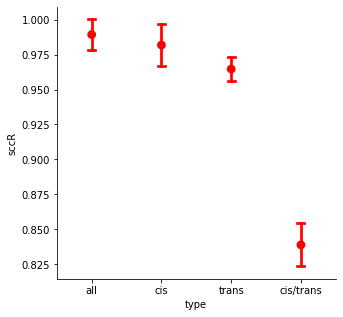

In [13]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.pointplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="red", alpha=1, join=False, ci="sd", capsize=0.1, order=["all", "cis", "trans", "cis/trans"])
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

## Write to file

In [14]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT.pdf"), bbox_inches="tight")

# Plot barplot of all cis and trans

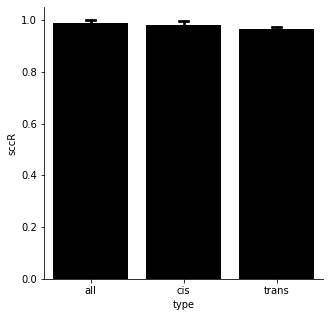

In [19]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.barplot(x="type", y="sccR", data=finFrameAll.loc[finFrameAll["type"] != "cis/trans", :], ax=ax, color="black", alpha=1,  ci="sd", capsize=0.1, order=["all", "cis", "trans"], errcolor="black")
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

In [20]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_bar_wocis_trans.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_bar_wocis_trans.pdf"), bbox_inches="tight")